# All pairs by sub-lists

This notebook shows how to cover all pairs in a list, when you can only process sublists of a maximum length in any one call

I thought I might need it for [OpenRouteService Matrix API](https://openrouteservice.org/dev/#/api-docs/v2/matrix/{profile}/post) in situations where you have more locations than the API limit of 50, until I realised the API allowed selection of specific sources and destinations from the longer list of locations. Maybe it still has some use in [customer matching](https://github.com/safetydave/maths-whimsy/blob/main/ml/matcher.ipynb) or other scenarios...

## Setup

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# size of our entire test list
all_len = 15

# sublist size
sub_len = 4

def reset():
    visited = np.zeros((all_len, all_len), dtype=int)
    calls = 0
    return visited, calls

In [3]:
def visualise(visited, calls):
    plt.imshow(visited, vmin = 0)
    plt.colorbar()
    plt.title(f'{calls} calls, {np.sum(visited)} pair visits ({int(100 * np.sum(visited) / visited.shape[0] ** 2)}% of {visited.shape[0] ** 2})')
    plt.show()

## Scenario

We have a pairwise matrix based on a list of elements, and we need to visit all of them with some set of calls

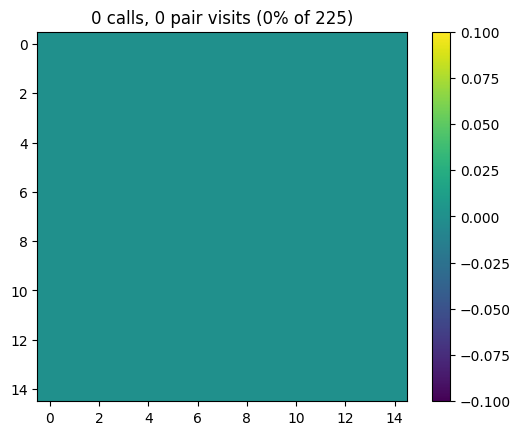

In [4]:
visited, calls = reset()
visualise(visited, calls)

The visit call takes a single list of ids, and will visit all pairs in that list, covering a "chunk" of the pairwise matrix

In [5]:
def visit_pairs_call(chunk_ids, array_size):
    pairs = np.meshgrid(chunk_ids, chunk_ids)
    visits = np.zeros((array_size, array_size), dtype=int)
    visits[pairs] = 1
    return visits

## Problem

The problem is that we're trying to cover 2 dimensions with a list that only has one dimension. Naive solutions only visit "diagonal" pairs.

Try continguous indices

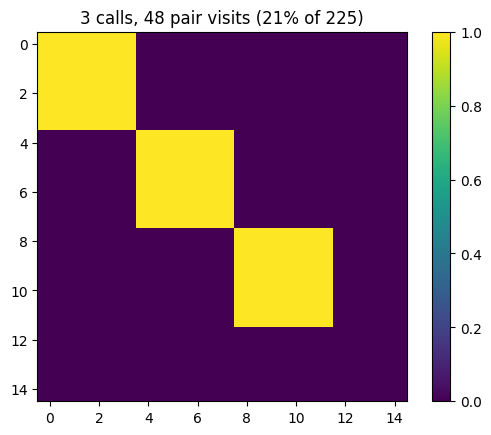

In [6]:
# recall sublist length 4

visited, calls = reset()

visited = visit_pairs_call([0, 1, 2, 3], all_len) + visited
visited = visit_pairs_call([4, 5, 6, 7], all_len) + visited
visited = visit_pairs_call([8, 9, 10, 11], all_len) + visited
# ...
calls = 3

visualise(visited, calls)

Try dispersed indices

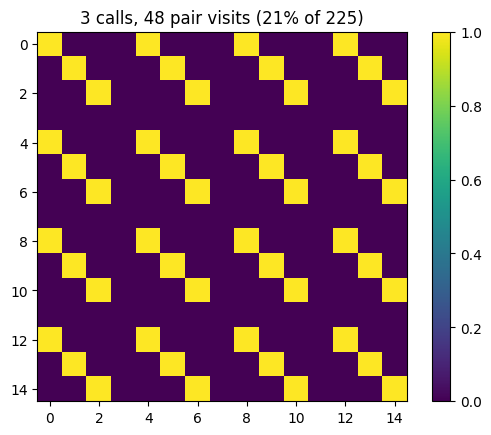

In [7]:
# recall sublist length 4

visited, calls = reset()

visited = visit_pairs_call([0, 4, 8, 12], all_len) + visited
visited = visit_pairs_call([1, 5, 9, 13], all_len) + visited
visited = visit_pairs_call([2, 6, 10, 14], all_len) + visited
# ...
calls = 3

visualise(visited, calls)

In both of these cases, we're left with unvisited pairs

## Solution

We can compose the sublists or chunks from smaller lists, so the head of one smaller list can pair with the tail of another to cover "off-diagonal" pairs.

In [8]:
def chunks_to_visit(chunk_size, array_size):
    # break down indices to half chunks
    half_chunk_size = chunk_size // 2
    splits = array_size // half_chunk_size
    if array_size % half_chunk_size != 0:
        splits = splits + 1
    half_chunked_ids = np.array_split(np.arange(array_size), splits)

    # combine half chunks to cover array
    chunks = []
    for i in range(len(half_chunked_ids)):
        for j in range(i + 1, len(half_chunked_ids)):
            chunk = np.concatenate((half_chunked_ids[i], half_chunked_ids[j]))
            chunks.append(chunk)
    return chunks

### First few chunks

First chunk

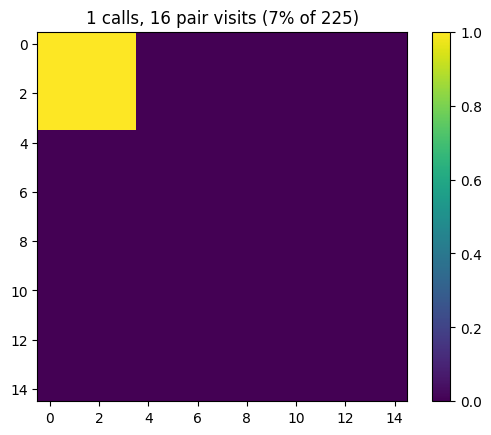

In [9]:
visited, calls = reset()

for c in chunks_to_visit(sub_len, all_len)[:1]:
    visited = visit_pairs_call(c, all_len) + visited
    calls = calls + 1

visualise(visited, calls)

Second chunk

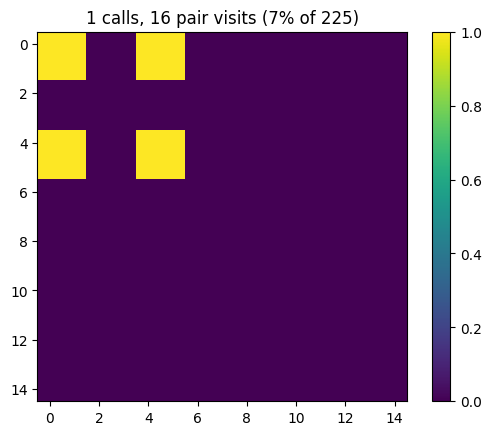

In [10]:
visited, calls = reset()

for c in chunks_to_visit(sub_len, all_len)[1:2]:
    visited = visit_pairs_call(c, all_len) + visited
    calls = calls + 1

visualise(visited, calls)

Third chunk

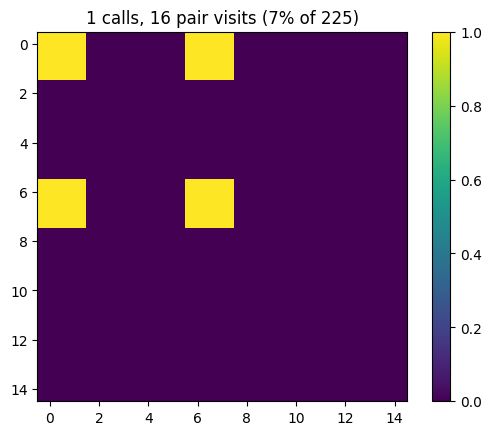

In [11]:
visited, calls = reset()

for c in chunks_to_visit(sub_len, all_len)[2:3]:
    visited = visit_pairs_call(c, all_len) + visited
    calls = calls + 1

visualise(visited, calls)

First three chunks combined

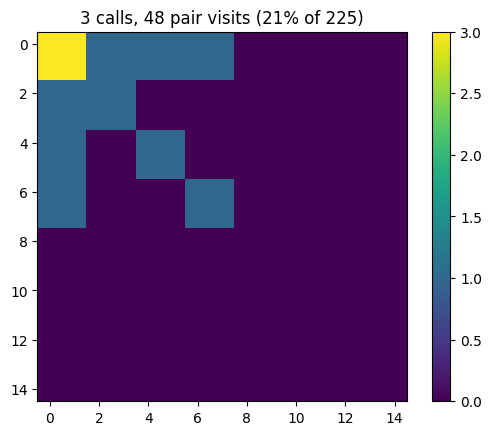

In [12]:
visited, calls = reset()

for c in chunks_to_visit(sub_len, all_len)[:3]:
    visited = visit_pairs_call(c, all_len) + visited
    calls = calls + 1

visualise(visited, calls)

### All chunks

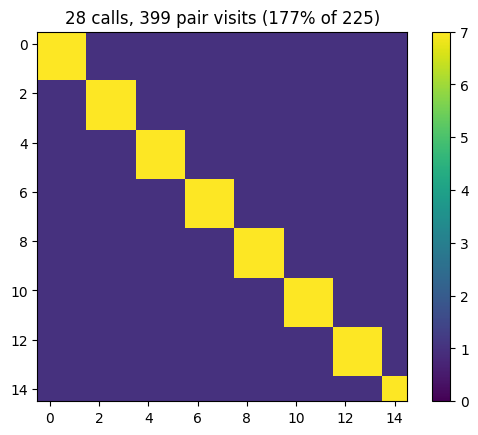

In [13]:
visited, calls = reset()

for c in chunks_to_visit(sub_len, all_len):
    visited = visit_pairs_call(c, all_len) + visited
    calls = calls + 1

visualise(visited, calls)

In [14]:
np.min(visited)

np.int64(1)

This approach means the diagonal blocks get visited multiple times as they appear in multiple calls, and the number of calls is also higher as a result. However, it's only the diagonal blocks that get visited many times, as all other pairs are only visited once. Maybe the multiple visits could be cached but we're only taking this approach assuming we don't have control over what happens when we visit all pairs in a chunk. It looks like it's about twice the visit effort and a little more than twice the call effort in the limit (empirically, as I haven't done the math).

## Better solutions?

May exist!